 <div style="text-align:center;">
   <span style="color:green; font-size:2em; font-weight:bold;">Exploratory Data Analysis (EDA)</span><br><br>
</div>


<span style="color:green; font-size:larger; font-weight:bold;">INTRODUCTION</span>

Dans cette partie, nous nous intéressons à l'analyse descriptive de la base de données "final_data" obtenue suite au nettoyage des bases de données initiales du fichier "Préparation_données.ipynb"

In [35]:
# Import des packages
from importlib import reload
import declarations as d
reload(d)

<module 'declarations' from 'c:\\Projet-Python\\monmodule\\declarations.py'>

In [36]:
# Importation  de la base de données
df = d.pd.read_csv("../final_data.csv")

In [37]:
# Visualisation
df.head()

,YEAR,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,1994-01,AUS,9.814137,0.501645,77.878049,0.963092
1,1994-01,SVN,14.650000,0.748256,73.404878,-0.115694
2,1994-01,CAN,10.700000,0.680429,77.871707,1.095258
3,1994-01,AUT,6.609708,0.779464,76.419512,0.384870
4,1994-01,PHL,9.450000,0.329061,67.942000,2.343515


In [38]:
# Telécharger le shapefile
world = d.gpd.read_file(d.gpd.datasets.get_path('naturalearth_lowres'))
world=world.rename(columns={'name': 'COUNTRY'})
world.head()

C:\Users\yousr\AppData\Local\Temp\ipykernel_21184\594538038.py:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,COUNTRY,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [39]:
# Sélectionner certaines colonnes
columns_to_keep = ['geometry', 'COUNTRY', 'continent']
world = world[columns_to_keep]

# Mettre les noms des colonnes en abréviation
world['COUNTRY'] = d.correct_country_name(world['COUNTRY'])

# Fusionner les deux DataFrames
world_df = d.pd.merge(world, df, how='inner', on=['COUNTRY'])


In [40]:
# Visualisation
world_df.head()

,geometry,COUNTRY,continent,YEAR,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,North America,1994-01,10.700000,0.680429,77.871707,1.095258
1,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,North America,1994-02,10.866667,0.680180,77.871707,1.095258
2,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,North America,1994-03,10.366667,0.686270,77.871707,1.095258
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,North America,1994-04,10.150000,0.689810,77.871707,1.095258
4,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,North America,1995-01,9.550000,0.694571,77.977317,1.034769


# <span style="color:green; text-align:center;">II- VISUALISATION DES DONNEES</span>

<Axes: >

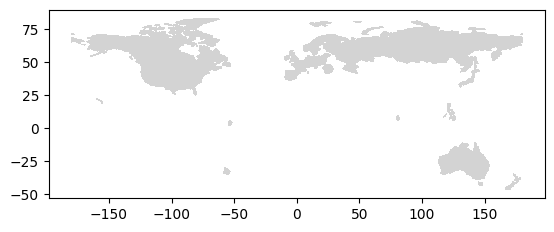

In [41]:
# Plot
world_df.plot(color='lightgrey')

Deux applications seront créer pour la visualition des données:
<div style="margin-left: 20px;">
-La premiere sera instantanné et à l'échelle mondiale. <br>
-La seconde c'est la représentation de la série temporelle par continent.
    </div>

In [42]:
# Créer un Dash app
app1 = d.dash.Dash(__name__)

# Définir le layout 
app1.layout = d.html.Div([
    # Sélecteur d'année
    d.dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': year, 'value': year} for year in sorted(world_df['YEAR'].unique())],
        value=world_df['YEAR'].min(),  #valeur par defaut de l'année
        multi=False,
    ),
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par defaut de la variable representée
        multi=False,
    ),
    d.dcc.Graph(id='choropleth-map'),
])

# Définir un callback  pour mettre à jour la carte sur l'année selectionnée 
@app1.callback(
    d.Output('choropleth-map', 'figure'),
    [d.Input('year-dropdown', 'value'),
     d.Input('variable-dropdown', 'value')]
)
def update_map(selected_year, selected_variable):
    subset_gdf = world_df[world_df['YEAR'] == selected_year]
    subset_gdf.index = subset_gdf['COUNTRY']
    fig = d.px.choropleth(
        subset_gdf,
        geojson=subset_gdf.geometry,
        locations=subset_gdf.index,
        color=selected_variable,
        projection="natural earth",
        title=f'{selected_variable} in {selected_year}',
    )
    fig.update_geos(fitbounds="locations", visible=True)
    return fig

# Executer l'application
if __name__ == '__main__':
    app1.run_server(debug=True, port=8050)


In [61]:

df=world_df.copy()
app2 = d.dash.Dash(__name__)

# Créer votre graphique initial
fig = d.px.line(df, x='YEAR', y=["Unemployment_rate"], color='COUNTRY')

# Créer la mise en page de votre application Dash
app2.layout = d.html.Div([
    # Sélecteur de continents
    d.dcc.Dropdown(
        id='continent-selector',
        options=[
            {'label': continent, 'value': continent}
            for continent in df['continent'].unique()
        ],
        multi=True,
        value=df['continent'].unique()  # Sélectionner tous les continents par défaut
    ),
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # Valeur par defaut de la variable representée
        multi=False,
    ),
    
    # Graphique
    d.dcc.Graph(
        id='line-chart',
        figure=fig
    )
])

# Définisser la logique de la mise à jour du graphique en fonction de la sélection du sélecteur
@app2.callback(
    d.Output('line-chart', 'figure'),
    [d.Input('variable-dropdown', 'value'),
     d.Input('continent-selector', 'value')]
)
def update_graph2(selected_variable, selected_continents):
    filtered_df = df[df['continent'].isin(selected_continents)]
    fig = d.px.line(filtered_df, x='YEAR', y=[selected_variable], color='COUNTRY',
                   labels={'YEAR': 'Année', selected_variable : f"{selected_variable}"})
    return fig


# Exécuter l'application Dash
if __name__ == '__main__':
    app2.run_server(debug=True, port=8051)


In [44]:
# Group by Country, sélectionner uniquement les 4 colonnes et faire la moyenne dans chaque groupe
df_group = df.groupby('COUNTRY')[
    ['Unemployment_rate', 'GDP_rate', 'life_expentancy', 'pop_growth_rate']
    ].mean().reset_index()

In [45]:
# Visualisation
df_group.head()

,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,AUS,6.027355,0.761392,80.916318,1.342107
1,AUT,7.236287,0.899732,79.720527,0.449969
2,BEL,7.774560,0.913237,79.483950,0.498965
3,BGR,10.575434,0.799515,72.878191,-0.792854
4,CAN,7.485185,0.922738,80.470733,1.032642


In [46]:
app3 = d.dash.Dash(__name__)

# Créer votre graphique initial
fig = d.px.bar(df_group, x='COUNTRY', y='Unemployment_rate', color='COUNTRY',
             labels={'COUNTRY': 'Pays', 'Unemployment_rate': 'Taux de chômage moyen'},
             #title='Taux de chômage moyen par pays sur la période 2019-2023',
             template='plotly_dark')

# Créer la mise en page de votre application Dash
app3.layout = d.html.Div([
    
    # Sélecteur de variables
    d.dcc.Dropdown(
        id='variable-dropdown',
        options=[
            {'label': 'Unemployment Rate', 'value': 'Unemployment_rate'},
            {'label': 'GDP growth Rate', 'value': 'GDP_rate'},
            {'label': 'Life expentancy', 'value': 'life_expentancy'},
            {'label': 'Population growth rate', 'value': 'pop_growth_rate'}
          
        ],
        value='Unemployment_rate',  # valeur par defaut de la variable representée
        multi=False,
    ),
    
    # Graphique
    d.dcc.Graph(
        id='bar',
        figure=fig
    )
])

# Définisser la logique de la mise à jour du graphique en fonction de la sélection du sélecteur
@app3.callback(
    d.Output('bar', 'figure'),
    [d.Input('variable-dropdown', 'value')]
)
def update_graph3(selected_variable):
    #fig = px.line(filtered_df, x='YEAR', y=["Unemployment_rate"], color='COUNTRY')
    fig = d.px.bar(df, x='COUNTRY', y=[selected_variable], color='COUNTRY',
                   labels={'COUNTRY': 'Pays', selected_variable: selected_variable},
                   template='plotly_dark')
    return fig


# Exécuter l'application Dash
if __name__ == '__main__':
    app3.run_server(debug=True, port=8052)


In [47]:
# Créer un graphique interactif avec Plotly Express
fig = d.px.bar(df_group, x='COUNTRY', y='Unemployment_rate', color='COUNTRY',
             labels={'COUNTRY': 'Pays', 'Unemployment_rate': 'Taux de chômage moyen'},
             title='Taux de chômage moyen par pays sur la période 2019-2023',
             template='plotly_dark')

# Afficher le graphique interactif
fig.show()